In [1]:
from pathlib import Path
import pandas as pd
from dotenv import dotenv_values

ENV_VARS = dotenv_values("../config/.env")
DPATH_RESULTS = Path(ENV_VARS["DPATH_FL_RESULTS"])
DPATH_FIGS = Path(ENV_VARS["DPATH_FL_FIGS"])
fpath_metrics = (
    DPATH_RESULTS
    / "2025_04_30/sklearn-classification-hinge-decline-age-case-aparc-55-3791/metrics-10_splits.tsv"
)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

DATASET_COLOUR_MAP = {
    "PPMI": "#D0A441",
    "ADNI": "#0CA789",
    "QPN": "#A6A6C6",
}

df_results = pd.concat(
    [
        # pd.read_csv(fpath_results_ba, sep='\t'),
        pd.read_csv(fpath_metrics, sep="\t"),
    ],
    axis="index",
)
df_results = df_results.query(
    'metric == "balanced_accuracy" or metric == "mean_absolute_error"'
)
# df_results = df_results.query('method != "fl_voting" and test_dataset != "all" and (metric == "balanced_accuracy" or metric == "r2")')
df_results["setup"] = df_results["setup"].map(
    {"silo": "Siloed", "mega": "Mega-analysis", "federated": "Federated"}
)
df_results["test_dataset"] = df_results["test_dataset"].str.upper()
df_results = df_results.reset_index(drop=True)
df_results

,setup,problem,framework,test_dataset,metric,i_split,score
0,Siloed,classification,sklearn,ADNI,balanced_accuracy,0,0.53
1,Siloed,classification,sklearn,PPMI,balanced_accuracy,0,0.50
2,Siloed,classification,sklearn,QPN,balanced_accuracy,0,1.00
3,Siloed,classification,sklearn,ADNI,balanced_accuracy,1,0.63
4,Siloed,classification,sklearn,PPMI,balanced_accuracy,1,0.60
...,...,...,...,...,...,...,...
61,Mega-analysis,classification,sklearn,PPMI,balanced_accuracy,0,0.50
62,Mega-analysis,classification,sklearn,QPN,balanced_accuracy,0,0.00
63,Mega-analysis,classification,sklearn,ADNI,balanced_accuracy,1,0.50
64,Mega-analysis,classification,sklearn,PPMI,balanced_accuracy,1,0.50


===== COGNITIVE DECLINE =====


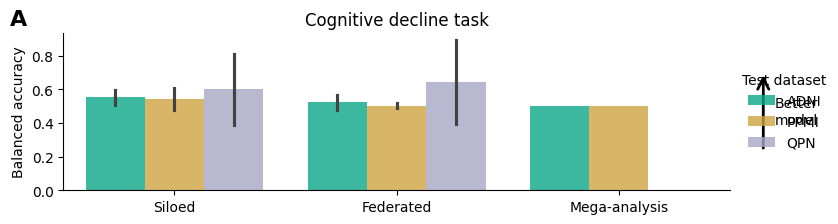

: 

: 

In [ ]:
import seaborn as sns

# df_results_null = df_results.query('is_null == True and test_dataset != "ALL"')
# df_results_nonnull = df_results.query('is_null == False and test_dataset != "ALL"')
# df_results_all = df_results.query('test_dataset == "ALL"')

bar_width = 0.8
null_width = 0.8

grid = sns.catplot(
    data=df_results,
    x="setup",
    y="score",
    hue="test_dataset",
    row="metric",
    kind="bar",
    errorbar="sd",
    order=["Siloed", "Federated", "Mega-analysis"],
    height=2.5,
    aspect=3,
    width=bar_width,
    sharex=False,
    sharey=False,
    palette=DATASET_COLOUR_MAP,
    alpha=0.8,
    saturation=1,
)

for i_ax, (metric, ax) in enumerate(grid.axes_dict.items()):

    task_name = {
        "balanced_accuracy": "cognitive decline",
        "mean_absolute_error": "brain age",
        "r2": "brain age",
    }[metric]
    print(f"===== {task_name.upper()} =====")

    ax.text(-0.08, 1.05, "ABCDE"[i_ax], transform=ax.transAxes, size=16, weight="bold")

    # for xticklabel, xtick in zip(ax.get_xticklabels(), ax.get_xticks()):

    #     method = xticklabel.get_text()
    #     df_mean_null_values = (
    #         df_results_null.query(f"metric == @metric")
    #         .groupby(["method", "test_dataset"])["score"]
    #         .describe()
    #     )
    #     df_mean_all_values = (
    #         df_results_all.query(f"metric == @metric")
    #         .groupby(["method", "test_dataset"])["score"]
    #         .describe()
    #     )

    #     if method in ["Siloed", "Federated", "Mega-analysis"]:
    #         mean_null_values = df_mean_null_values.loc["Siloed", "mean"]
    #         mean_all_values = df_mean_all_values.loc[method, "mean"].item()
    #     # elif xticklabel.get_text() == 'Mega-analysis':
    #     #     mean_null_values = df_mean_null_values.loc['Mega-analysis', 'mean']
    #     else:
    #         raise ValueError(f"Unknown method: {method}")

    # print(f"----- {method.capitalize()} -----")
    # print("MEAN NULL")
    # print(mean_null_values)
    # print("MEAN All")
    # print(mean_all_values)

    # if metric == "mean_absolute_error":
    #     best_null_value = mean_null_values.min()
    # else:
    #     best_null_value = mean_null_values.max()

    # # ax.plot([xtick - null_width/2, xtick + null_width/2], [best_null_value, best_null_value], 'k--', alpha=0.5)
    # ax.plot(
    #     [xtick - null_width / 2, xtick + null_width / 2],
    #     [mean_all_values, mean_all_values],
    #     "r:",
    #     alpha=0.75,
    # )
    # ax.axhline(best_null_value, color="k", linestyle="--", alpha=0.5)

    # ax.set_ylabel('')
    # ax.set_title(f"{metric.capitalize().replace('_', ' ')} for {task_name} task")
    ax.set_ylabel(metric.capitalize().replace("_", " "))
    ax.set_title(f"{task_name.capitalize()} task")
    ax.set_xlabel("")

    if metric == "mean_absolute_error":
        arrowstyle = "->"
    else:
        arrowstyle = "<-"

    ax.annotate(
        "",
        xy=(1.05, 0.25),
        xycoords="axes fraction",
        xytext=(1.05, 0.75),
        arrowprops=dict(arrowstyle=arrowstyle, linewidth=2, mutation_scale=20),
    )
    ax.annotate(
        "Better\nmodel",
        xy=(1.1, 0.5),
        xycoords="axes fraction",
        ha="center",
        va="center",
    )

grid.legend.set_title("Test dataset")

In [ ]:
DPATH_FIGS.mkdir(exist_ok=True)

fpath_fig = DPATH_FIGS / f"metrics-combined.png"
# grid.savefig(fpath_fig, dpi=300)

: 

: 